In [3]:
import glob, os, sys
import numpy as np
import csv
import cv2
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import numpy as np
from PIL import Image
import networkx as nx
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt
import ebooklib
from ebooklib import epub
import random
import re
import os
import nltk
from nltk.corpus import words
import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names
from sklearn.decomposition import PCA
import scipy.spatial
from matplotlib import cm
import matplotlib.image as mpimg
import pandas as pd
import jieba
from sklearn.metrics.pairwise import linear_kernel
from nltk import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn
from matplotlib.colors import LinearSegmentedColormap


In [4]:
%cd D:\YeqinHUANG_Collection\ucl\Term3\skill\python

D:\YeqinHUANG_Collection\ucl\Term3\skill\python


In [1]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argmin(distSq, axis=None), distSq.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        np.random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM
import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'sqeuclidean')[0][0]
    QE = sumSqDist/len(data)
    return QE
    
# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    distSq = (np.square(SOM - x)).sum(axis=2)
    return np.unravel_index(np.argpartition(distSq, 2, axis=None)[2], distSq.shape)
    

def calculateTE(SOM, data):
    failed = 0
    for d in data:
        g1, h1 = find_BMU(SOM, d)
        g2, h2 = find_BMU_2(SOM, d)
        coord1 = np.array([g1, h1])
        coord2 = np.array([g2, h2])
        dist = euclidean(coord1, coord2)

        if dist > 1:
            failed += 1

    return failed / len(data)
    
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[euclidean(normalP, c) for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):

    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64) #初始化空矩阵存储计算出的距离值。矩阵大小与SOM的行数和列数相同

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            #对每个节点，计算其与其周围的欧氏距离（上下左右及对角线）
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh #计算与邻居节点的平均距离
    u_values = (u_values - 1) * -1
    return u_values

In [5]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X


def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [6]:
model.save_weights('database03_video')
model.load_weights('database03_video')

In [7]:
def processImage(imagePath, model):
    im = load_image(imagePath)
    f = model.predict(im)[0]
    return f

In [13]:
import os
import cv2

def extract_frames(input_folder, output_folder, interval_seconds=5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.mp4'):
            video_path = os.path.join(input_folder, filename)
            video_name = os.path.splitext(filename)[0]

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            frame_number = 0
            while True:
                frame_number += int(interval_seconds * fps)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                ret, frame = cap.read()

                # 保存提取的帧
                if ret:
                    frame_output_path = os.path.join(output_folder, f'{video_name}_{frame_number//int(fps)}s.jpg')
                    cv2.imwrite(frame_output_path, frame)
                else:
                    break

            cap.release()

input_folder = 'database03_video'
output_folder = 'frametest'

extract_frames(input_folder, output_folder, interval_seconds=5)


In [44]:
def vectorize_images_in_folder(folder_path, model):
    image_features_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            feature = processImage(image_path, model)
            image_features_list.append({'filename': filename, 'feature': feature})

    return image_features_list

In [156]:
folder_path = 'frametest'
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224, 224, 3), 
    include_top=False, 
    pooling='avg'
)

image_features_dict = vectorize_images_in_folder(folder_path, model)

In [46]:
import pickle

with open('VideoSOMFeatures.pkl', 'wb') as pickle_file:
    pickle.dump(image_features_dict, pickle_file)

print("Results have been saved to feature_image_pairs.pkl")

Results have been saved to feature_image_pairs.pkl


In [47]:
import pickle
with open('VideoSOMFeatures.pkl', 'rb') as pickle_file:
    image_features_dict = pickle.load(pickle_file)

In [49]:
image_features_dict[0]

{'filename': 'video_100_10s.jpg',
 'feature': array([0.02124895, 0.8509494 , 0.86517644, ..., 1.3836501 , 0.5627869 ,
        0.30581886], dtype=float32)}

In [50]:
colors = [
    (0, "#e9fcfa"),  # 绿
    (0.4, "#a6f3e9"),  # 绿
    (0.8, "#ffe6ef"),  # 粉
    (1, "#ffb3cd")  # 粉
]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

In [51]:
# Dimensions of the SOM grid
m = 10
n = 10
train_data7 = [pair['feature'] for pair in image_features_dict]
n_train_data7 = normalise(train_data7, train_data7)

0
1
2
3


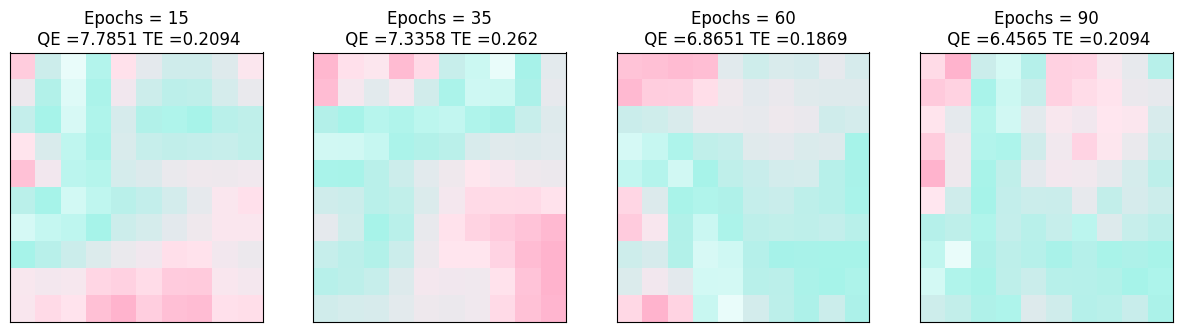

In [52]:
from matplotlib.colors import LinearSegmentedColormap
total_epochs = 0
SOMS7 = []
vector_size = 1024 
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))

for epochs, i in zip([15, 20, 25, 30], range(0,4)):
    print(i)
    total_epochs += epochs
    rand = np.random.RandomState(0)
    SOM7 = rand.uniform(0,1,(m,n,vector_size))
    SOM7 = train_SOM(SOM7, n_train_data7, learn_rate = .5, radius_sq = 7, epochs = epochs)
    SOMS7.append(SOM7)
    QE = round(calculateQE(SOM7, n_train_data7), 4)
    TE = round(calculateTE(SOM7, n_train_data7), 4)
    
    ax[i].imshow(u_matrix(SOM7),cmap=cmap,aspect='auto')
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [53]:
SOM7 = SOMS7[2]

In [55]:
with open('Database03_VideoFrameSOM2.pkl', 'wb') as f:
    pickle.dump(SOM7, f)

In [56]:
import pickle
with open('Database03_VideoFrameSOM2.pkl', 'rb') as f:
    SOM7= pickle.load(f)

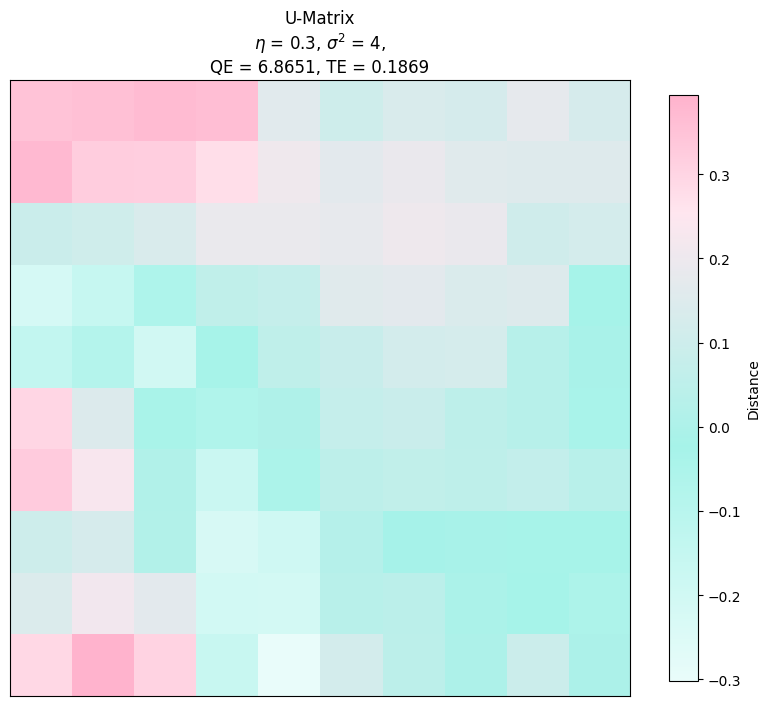

In [57]:
u_matrix_values = u_matrix(SOM7)
QE = round(calculateQE(SOM7, n_train_data7), 4)
TE = round(calculateTE(SOM7, n_train_data7), 4)

plt.figure(figsize=(10, 8))
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [58]:
SOMimages2 = []
for i in range(len(SOM7)):
    row7 = []
    for j in range(len(SOM7[0])):
        row7.append([])
    SOMimages2.append(row7)

In [60]:
for fi in image_features_dict:
    g,h = find_BMU(SOM7, normalise(train_data7, fi['feature']))
    SOMimages2[g][h].append(fi)

In [61]:
[[len(c) for c in r] for r in SOMimages2]

[[18, 17, 21, 11, 9, 15, 18, 7, 13, 19],
 [20, 7, 7, 15, 9, 5, 5, 8, 10, 12],
 [23, 13, 15, 10, 9, 16, 10, 2, 16, 11],
 [3, 3, 1, 6, 15, 6, 13, 15, 5, 14],
 [24, 1, 18, 6, 7, 4, 7, 6, 9, 5],
 [24, 10, 3, 5, 9, 7, 10, 11, 4, 14],
 [26, 16, 4, 12, 4, 8, 5, 8, 6, 19],
 [11, 12, 14, 0, 8, 6, 11, 4, 8, 6],
 [6, 10, 14, 3, 4, 14, 1, 7, 8, 16],
 [27, 21, 25, 10, 12, 7, 15, 17, 8, 16]]

In [69]:
def distance_between(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return np.linalg.norm(a - b)

In [70]:
def find_closest_image_index(distance):
    closest_index = 0
    distance_closest = distance[0]

    for index in range(1, len(distance)):
        if distance[index] < distance_closest:
            distance_closest = distance[index]
            closest_index = index

    return closest_index

In [71]:
def get_closest_image(a,b):
    cell = SOM7[a][b]
    distance = [distance_between(cell, i['feature']) for i in SOMimages2[a][b]]
    closest_image_index=find_closest_image_index(distance)
    return closest_image_index

In [77]:
def img_reshape(img):
    main_folder_path = r'D:\YeqinHUANG_Collection\ucl\Term3\skill\python\frametest'
    img_path = os.path.join(main_folder_path, img)
    img = Image.open(img_path).convert('RGB')
    img = img.resize((100, 100))
    img = np.asarray(img)
    return img

In [80]:
from mpl_toolkits.axes_grid1 import ImageGrid
def generate_SOMimages_grid(SOMimages):
    imageGrid = []
    for g in range(len(SOMimages)):
        row = SOMimages[g]
        for h in range(len(row)):
            cell = row[h]
            if len(cell) > 0:
                closest_image_index=get_closest_image(g,h)
                imageGrid.append(cell[closest_image_index]['filename'])
            else:
                imageGrid.append('white.png')
            
    img_arr = []
    for image in imageGrid:
        img_arr.append(img_reshape(image))
        
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes
                    ) 
    
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.axis('off')
    SOMimages_grid=plt.show()
    
    return SOMimages_grid

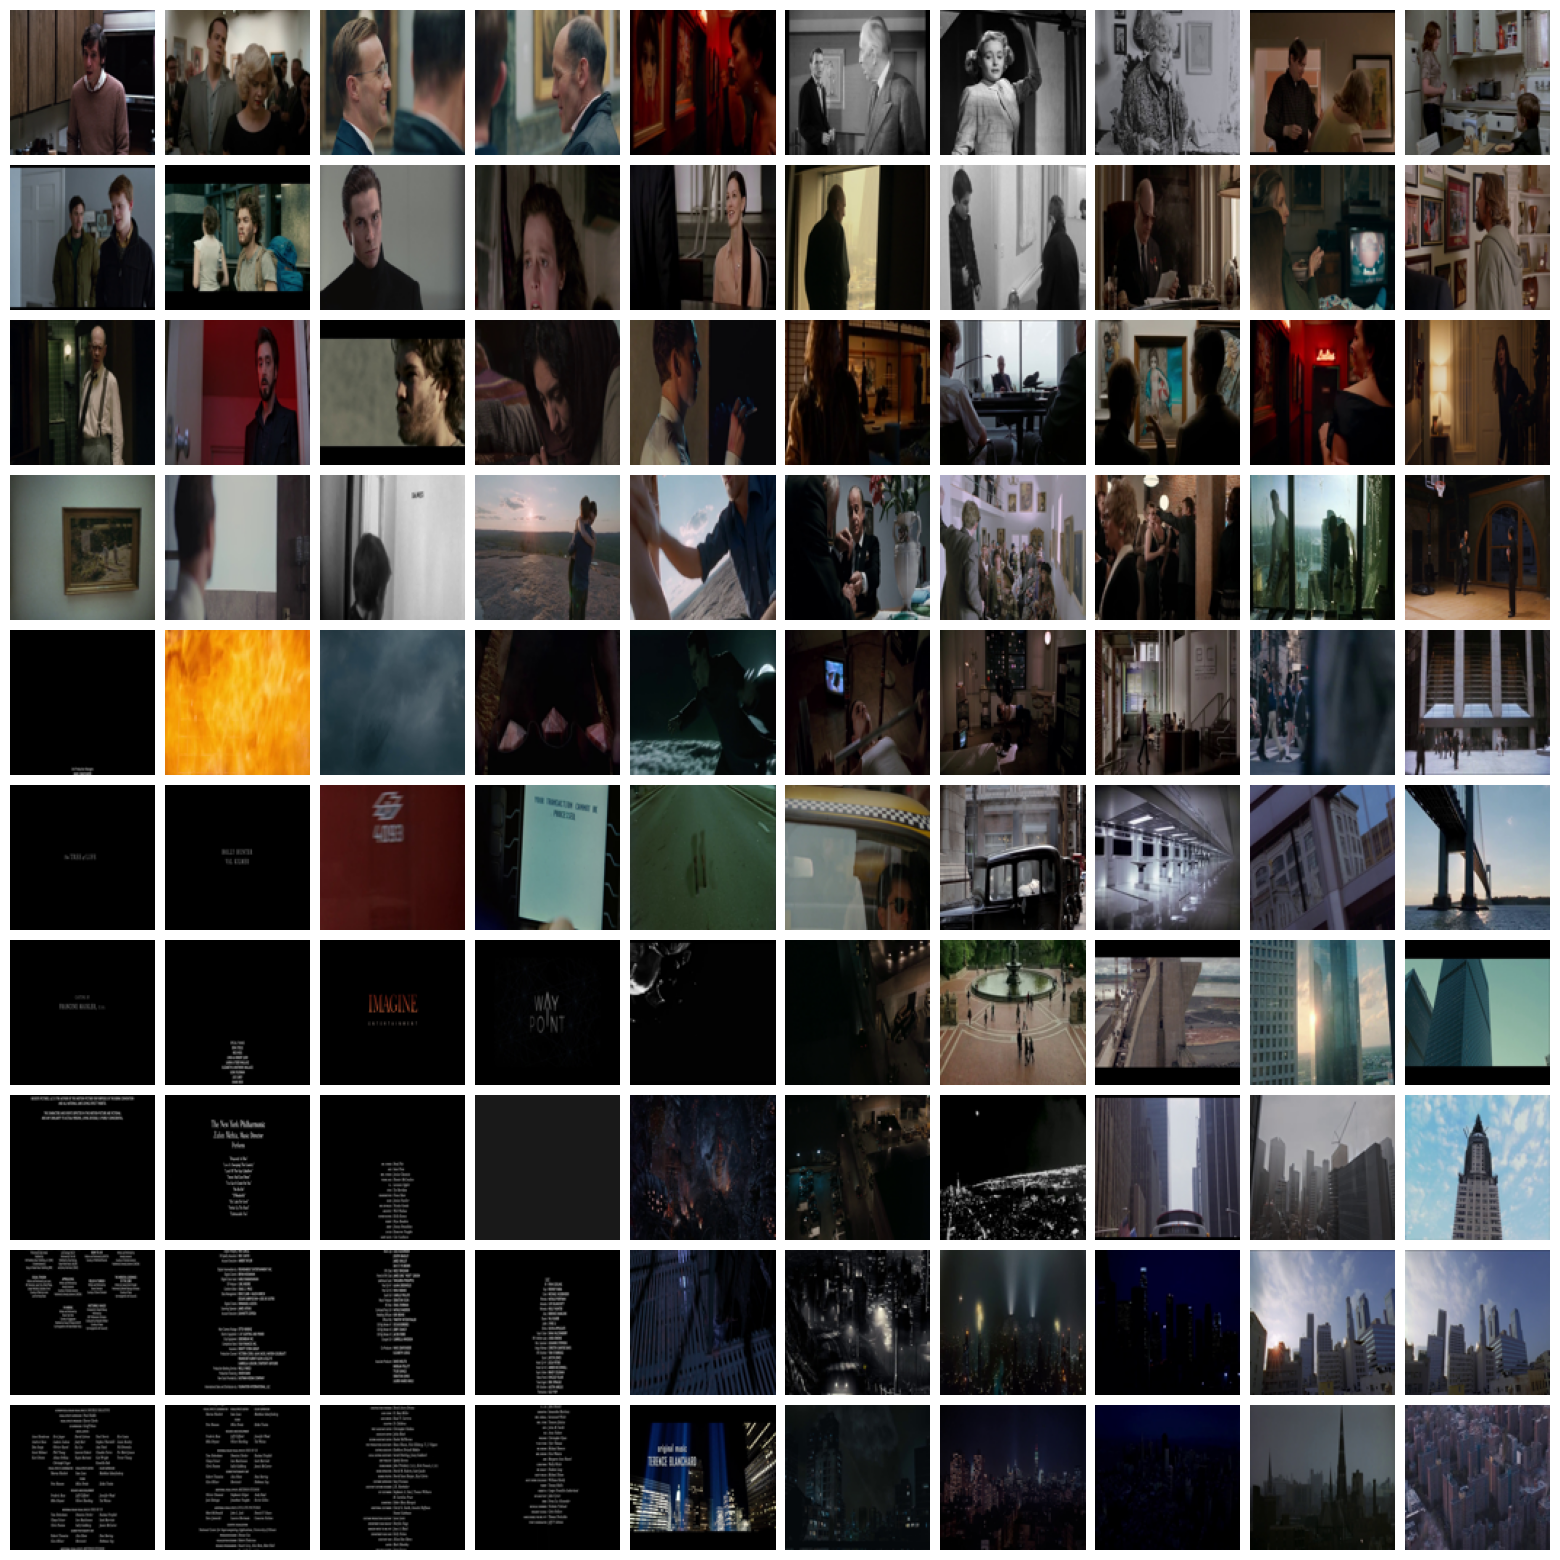

In [81]:
generate_SOMimages_grid(SOMimages2)

In [82]:
video_picture_data_dict3 = [[[] for _ in range(len(SOM7[0]))] for _ in range(len(SOM7))]

# 遍历每个格子中的列表
for row in SOMimages2:
    for cell in row:
        for item in cell:
            if not isinstance(item, dict) or 'feature' not in item or 'filename' not in item:
                continue

            features = item['feature']
            path = item['filename']

            g, h = find_BMU(SOM7, features)

            if 0 <= g < len(SOM7) and 0 <= h < len(SOM7[0]):
                video_picture_data_dict3[g][h].append({'features': features, 'filename': path})
            else:
                print(f"Warning: Index out of range ({g}, {h}) for path: {path}")


In [84]:
def get_closest_image3(a,b):
  cell = SOM7[a][b]
  distance = [distance_between(cell, i['features']) for i in video_picture_data_dict3[a][b]]
  closest_image_index=find_closest_image_index(distance)
  return closest_image_index

In [88]:
def searchvideopicturesom7(query):
    result = []
    query_features = []
    path = query
    q_f = processImage(path, model)
    query_features.append(q_f)

    # 调试信息
    print(f"Query features shape: {np.array(query_features).shape}")
    activatedSOM = activate(n_train_data7, SOM7, query_features)

    # 检查 BMU 查找是否正常
    g, h = find_BMU(SOM7, query_features[0])
    print(f"BMU location: ({g}, {h})")

    # 显示 U-Matrix 结果
    plt.figure(figsize=(5, 4))
    im = plt.imshow(activatedSOM, cmap=cmap, aspect='auto')
    plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    # 获取最近的图像索引
    closest_image_index = get_closest_image2(g, h)
    result.append(video_picture_data_dict3[g][h][closest_image_index]['filename'])
    return result

1/1 [==============================] - 0s 40ms/step
Query features shape: (1, 1024)
BMU location: (0, 7)


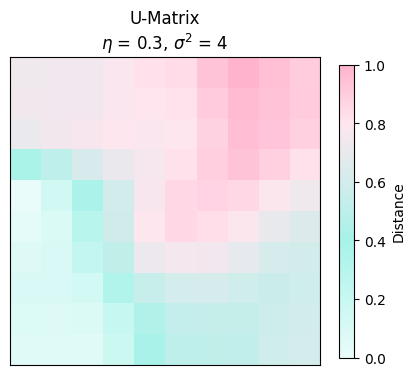

In [91]:
query = r'D:\YeqinHUANG_Collection\ucl\Term3\skill\python\database02_photo\museumReinaSofia\ReinaSofia_437.jpg'
result7 = searchvideopicturesom7(query)

In [92]:
result7

['video_16_10s.jpg']

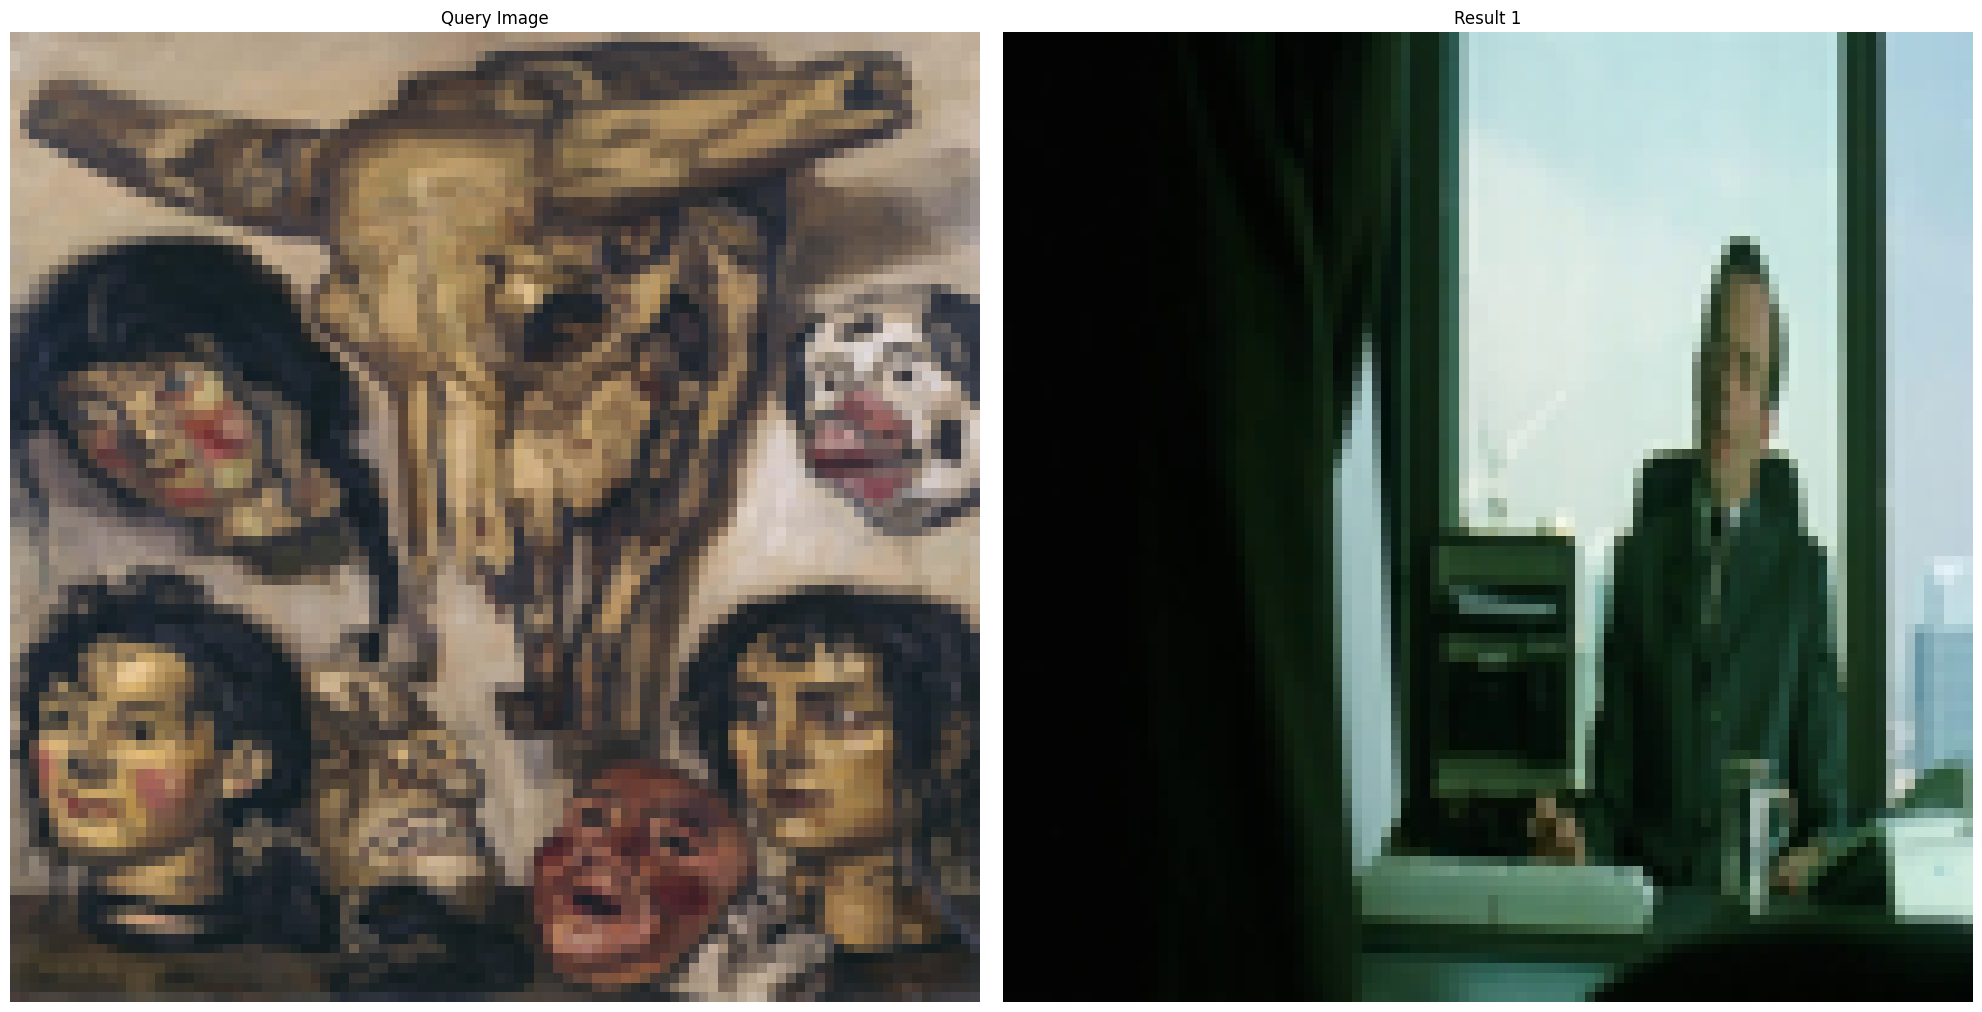

In [98]:
def show_query_and_results(query_image_path, result_image_paths):
    image_paths = [query_image_path] + result_image_paths
    titles = ["Query Image"] + [f"Result {i+1}" for i in range(len(result_image_paths))]

    n_images = len(image_paths)
    fig, axes = plt.subplots(1, n_images, figsize=(5 * n_images, 5))

    if n_images == 1:
        axes = [axes]

    for ax, path, title in zip(axes, image_paths, titles):
        try:
            # 使用 img_reshape 加载和调整图像大小
            image = img_reshape(path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(title)
        except Exception as e:
            ax.set_title(f"Error: {e}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

show_query_and_results(query, result7)

In [144]:
import os
import re
from moviepy.editor import VideoFileClip

def extract_video_from_video(video_folder, result7, output_folder):
    for item in result7:
        video_name_with_time = item.split('_')
        video_name = '_'.join(video_name_with_time[:-1]) 
        start_time_str = video_name_with_time[-1]
        
        match = re.search(r'(\d+)s', start_time_str)
        if match:
            start_second = int(match.group(1))
        else:
            print(f"Failed to extract start time from {start_time_str}")
            continue

        # 拼接视频文件路径
        video_path = os.path.join(video_folder, video_name + '.mp4')
        print(f"Processing video: {video_path}")

        try:
            clip = VideoFileClip(video_path)
            end_second = start_second + 5
            subclip = clip.subclip(start_second, end_second)

            output_video_path = os.path.join(output_folder, f'{video_name}_{start_second}s_to_{end_second}s_extracted.mp4')
            subclip.write_videofile(output_video_path, codec='libx264')

            print(f"Extracted video saved to: {output_video_path}")
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")


output_folder = r'D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos'
video_folder = r'D:\YeqinHUANG_Collection\ucl\Term3\skill\python\database03_video'

Processing video: D:\YeqinHUANG_Collection\ucl\Term3\skill\python\database03_video\video_16.mp4
Moviepy - Building video D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos\video_16_10s_to_15s_extracted.mp4.
MoviePy - Writing audio in video_16_10s_to_15s_extractedTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos\video_16_10s_to_15s_extracted.mp4



Moviepy - Done !
Moviepy - video ready D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos\video_16_10s_to_15s_extracted.mp4
Extracted video saved to: D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos\video_16_10s_to_15s_extracted.mp4
First frame saved to: D:\YeqinHUANG_Collection\ucl\Term3\skill\python\output_videos\video_16_10s_first_frame.png


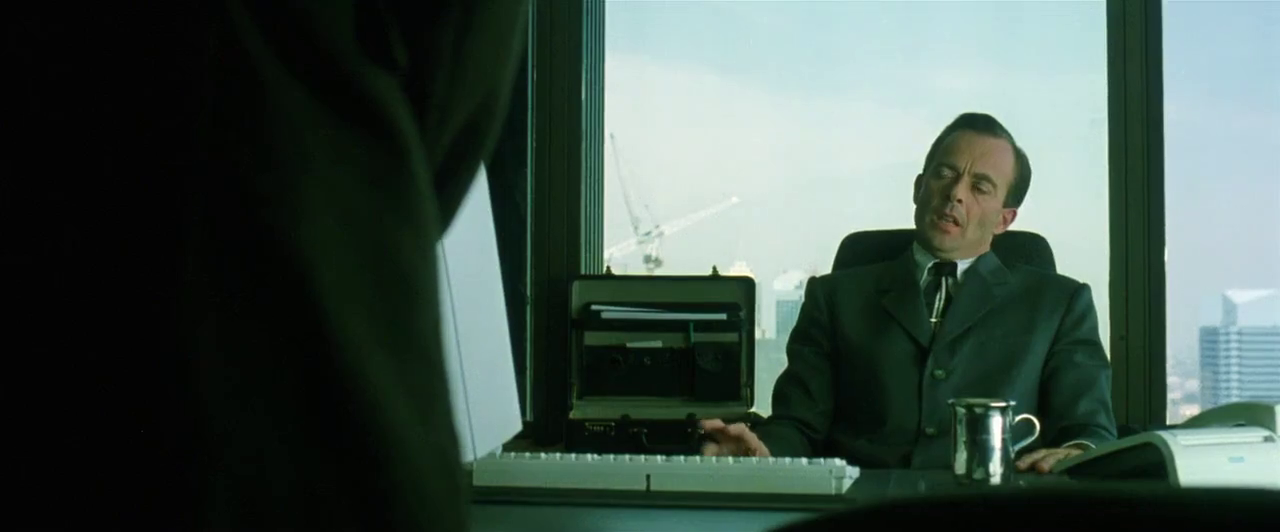

In [155]:
extract_video_from_video(video_folder, result7, output_folder)